In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import matplotlib.image as mpimg
import pandas as pd
import wandb
import random
import numpy as np
from wandb.keras import WandbCallback
import visualkeras


In [4]:
#FIXME: When upload dataset other C:/Users/User-pc/Downloads/Python/dataset_project
BASE_DIR = 'C:/Users/User-pc/Downloads/Python/dataset_project'
#C:/Users/tushar shende/Downloads/archive (1).zip/teeth_dataset
train_folder = 'C:/Users/User-pc/Downloads/Python/dataset_project/train'
test_folder = 'C:/Users/User-pc/Downloads/Python/dataset_project/test'
#train_folder = os.path.join(BASE_DIR,'train')
#test_folder = os.path.join(BASE_DIR,'test')

# label_ = os.listdir(train_folder) #[caries,no-caries]
# TRAIN TO CSV
df_train = pd.DataFrame()
df_image = []
df_label = []

label_num = 0

for i_label in os.listdir(train_folder):
    for j_image in sorted(os.listdir(os.path.join(train_folder,i_label))): #return full images within the folder
        df_image.append(os.path.join('train',i_label,j_image)) # return path_image
        df_label.append(label_num)
    label_num += 1
df_train['images'] = df_image
df_train['target'] = df_label
#caries = 0, no-caries = 1
df_train.to_csv('./train.csv')


# TEST TO CSV
df_test = pd.DataFrame()
df_image = []
df_label = []

label_num = 0

for i_label in os.listdir(test_folder):
    for j_image in sorted(os.listdir(os.path.join(test_folder,i_label))): #return full images within the folder
        df_image.append(os.path.join('test',i_label,j_image))
        df_label.append(label_num)
    label_num += 1
df_test['images'] = df_image
df_test['target'] = df_label
#caries = 1, no-caries = 0
df_test.to_csv('./test.csv')
#print(train_folder)


In [5]:
df_train.head(78),df_test.tail(55)

(                     images  target
 0    train\caries\d (1).jpg       0
 1   train\caries\d (10).jpg       0
 2   train\caries\d (11).jpg       0
 3   train\caries\d (12).jpg       0
 4   train\caries\d (13).jpg       0
 ..                      ...     ...
 73  train\caries\d (76).jpg       0
 74  train\caries\d (77).jpg       0
 75  train\caries\d (78).jpg       0
 76   train\caries\d (8).jpg       0
 77   train\caries\d (9).jpg       0
 
 [78 rows x 2 columns],
                            images  target
 0         test\caries\d (100).jpg       0
 1         test\caries\d (101).jpg       0
 2         test\caries\d (102).jpg       0
 3         test\caries\d (103).jpg       0
 4         test\caries\d (104).jpg       0
 5         test\caries\d (105).jpg       0
 6         test\caries\d (106).jpg       0
 7         test\caries\d (107).jpg       0
 8         test\caries\d (108).jpg       0
 9         test\caries\d (109).jpg       0
 10        test\caries\d (110).jpg       0
 11        tes

In [6]:
import albumentations as A
os.makedirs('teeth_dataset',exist_ok=True)
os.makedirs('teeth_dataset/train',exist_ok=True)
os.makedirs('teeth_dataset/test',exist_ok=True)
os.makedirs('teeth_dataset/train/caries',exist_ok=True)
os.makedirs('teeth_dataset/train/no-caries',exist_ok=True)
os.makedirs('teeth_dataset/test/caries',exist_ok=True)
os.makedirs('teeth_dataset/test/no-caries',exist_ok=True)


In [7]:
transform = A.Compose([
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.6),
     A.OneOf([
                        A.MotionBlur(blur_limit=3),
                        A.MedianBlur(blur_limit=3),
                        A.GaussianBlur(blur_limit=(1,3)),
                        A.GaussNoise(var_limit=(5.0, 15.0)),
                    ], p=0.7),
    A.OneOf([
                        A.OpticalDistortion(distort_limit=1.0),
                        A.GridDistortion(num_steps=5, distort_limit=1.),
                        A.ElasticTransform(alpha=3),
                    ], p=0.7),
    A.CLAHE(clip_limit=4.0, p=0.7),
    A.ColorJitter(p=0.7,hue=0.1),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
    A.CoarseDropout(max_holes=1, max_height=int(50 * 0.375), max_width=int(50 * 0.375), min_holes=1, min_height=None, min_width=None, fill_value=0, mask_fill_value=None, always_apply=False, p=0.7),
    
])


In [8]:
print('Number of train images:',len(df_train))
print('Number of test images:',len(df_test))


Number of train images: 128
Number of test images: 55


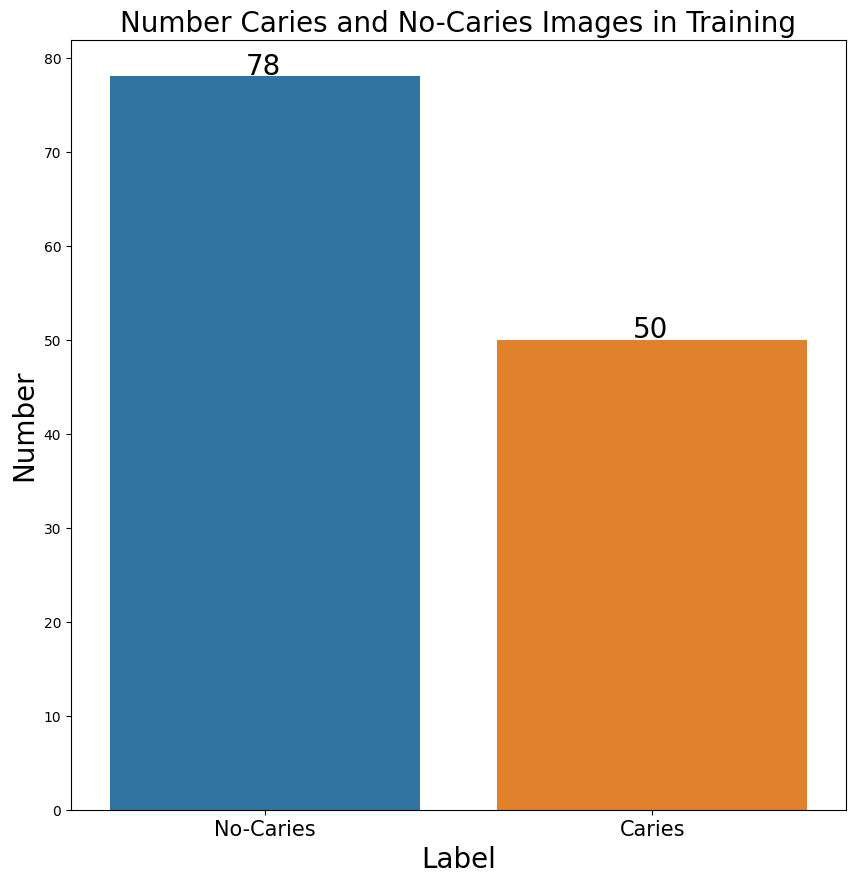

In [9]:
plt.figure(figsize=(10,10))
ax = sns.countplot(x = 'target', data = df_train)
ax.set_title('Number Caries and No-Caries Images in Training', size=20)
ax.set_xlabel("Label",fontsize=20)
ax.set_ylabel("Number",fontsize=20)
ax.set_xticklabels(['No-Caries', 'Caries'],fontsize=15)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.2),fontsize=20)


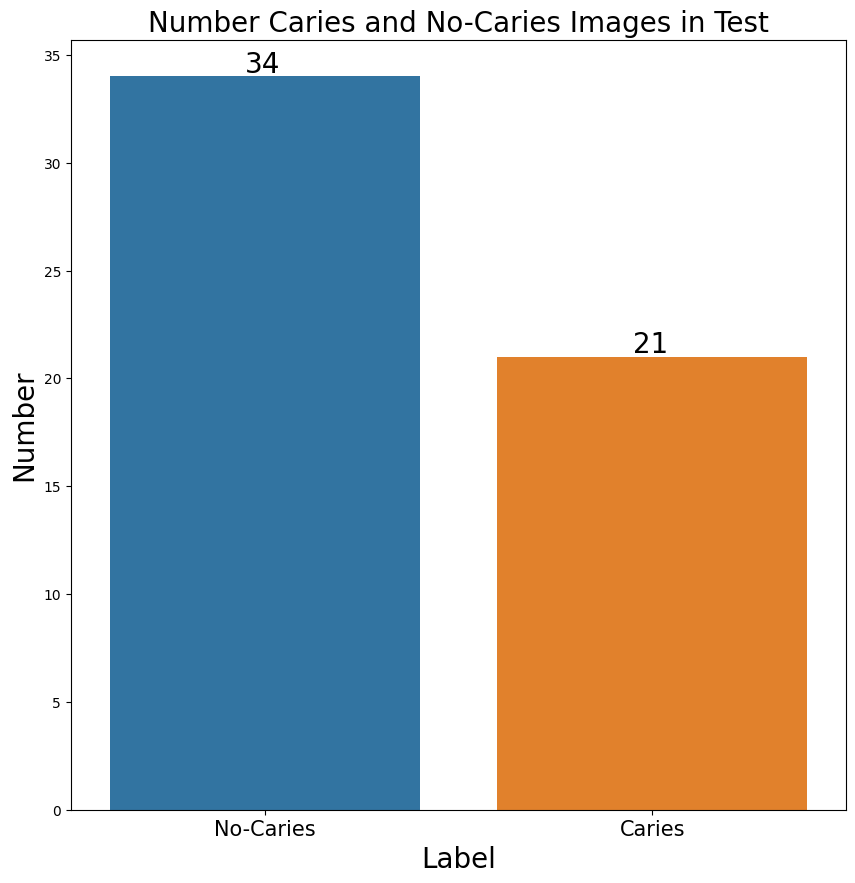

In [10]:
plt.figure(figsize=(10,10))
ax = sns.countplot(x = 'target', data = df_test)
ax.set_title('Number Caries and No-Caries Images in Test', size=20)
ax.set_xlabel("Label",fontsize=20)
ax.set_ylabel("Number",fontsize=20)
ax.set_xticklabels(['No-Caries', 'Caries'],fontsize=15)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.2),fontsize=20)


Text(0.5, 1.0, '% Carries and No-Caries In Train')

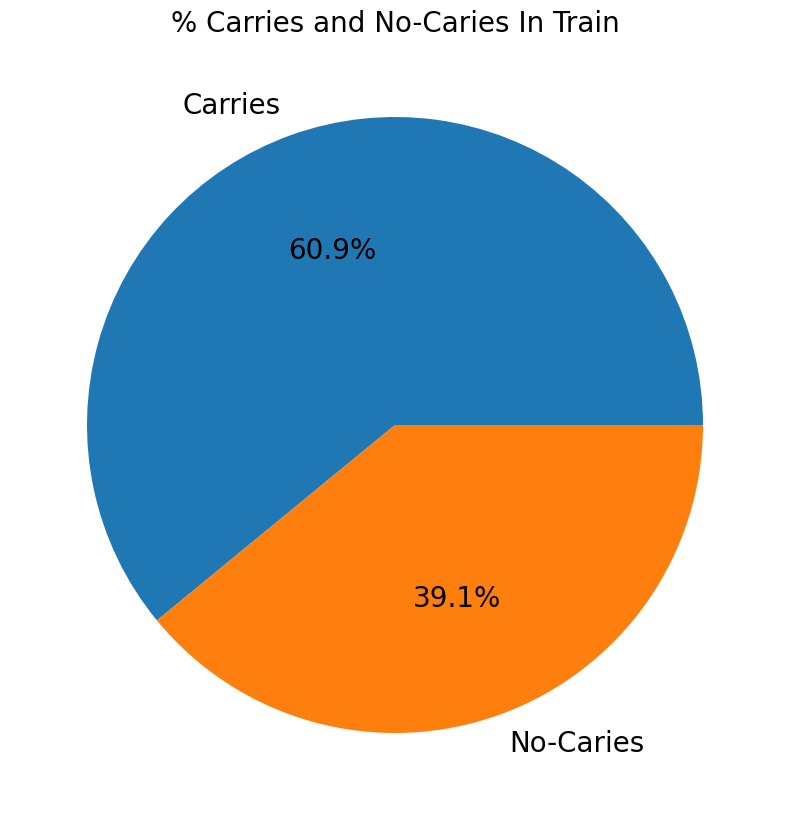

In [11]:
bar, ax = plt.subplots(figsize = (10,10))
bar.patch.set_facecolor('white')
plt.pie(df_train['target'].value_counts(), 
        labels = ['Carries','No-Caries'], 
        autopct="%.1f%%",textprops={'fontsize':20})
plt.title('% Carries and No-Caries In Train', size=20)


Text(0.5, 1.0, '% Carries and No-Caries In Test')

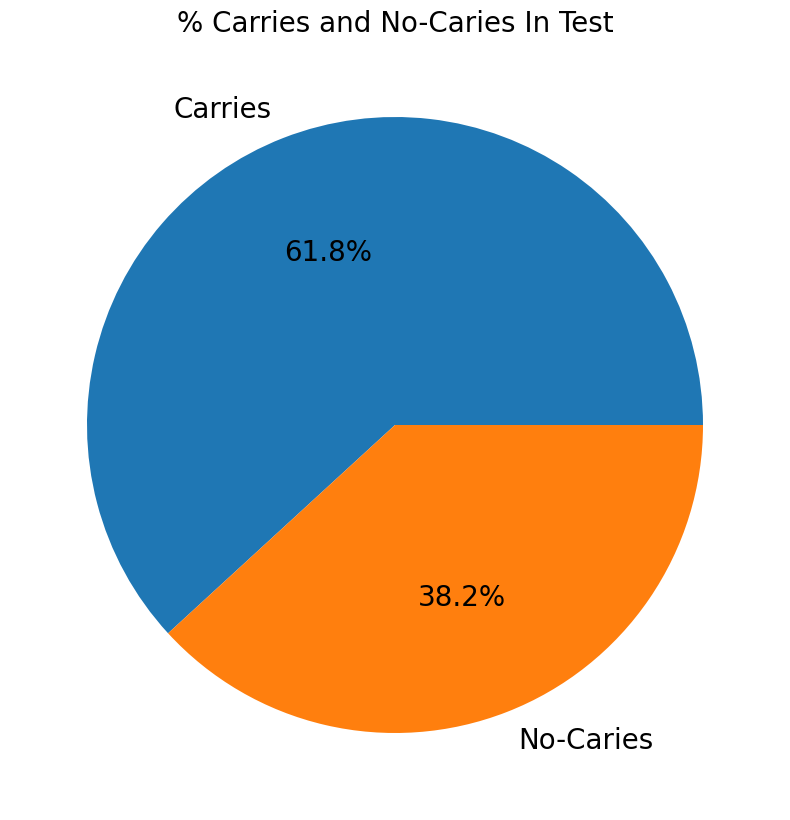

In [12]:
bar, ax = plt.subplots(figsize = (10,10))
bar.patch.set_facecolor('white')
plt.pie(df_test['target'].value_counts(), 
        labels = ['Carries','No-Caries'], 
        autopct="%.1f%%",textprops={'fontsize':20})
plt.title('% Carries and No-Caries In Test', size=20)


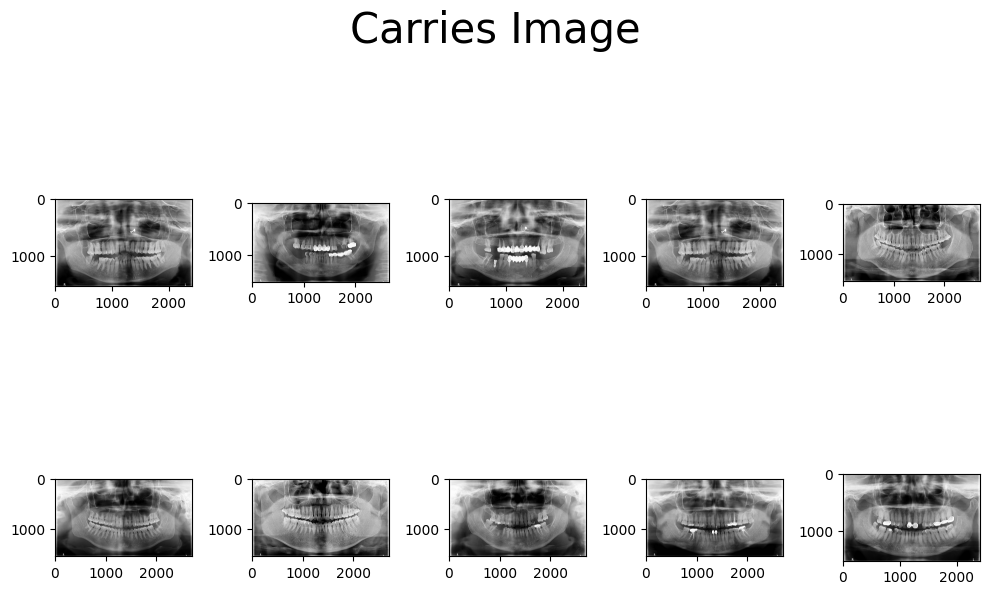

In [14]:
f , ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
f.suptitle('Carries Image',x=0.5,y=0.8,fontsize=30,verticalalignment='bottom')
k = 0
for i in range(2):
    for j in range(5):
        #img = cv2.imread("C:/Users/tushar shende/Downloads/Python/dataset_project/train/caries")
        img = cv2.imread(os.path.join('C:/Users/User-pc/Downloads/Python/dataset_project','train','caries',random.choice(os.listdir(os.path.join('C:/Users/User-pc/Downloads/Python/dataset_project','train','caries')))))
        # im_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
        ax[i,j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        k = k + 1
    plt.tight_layout()


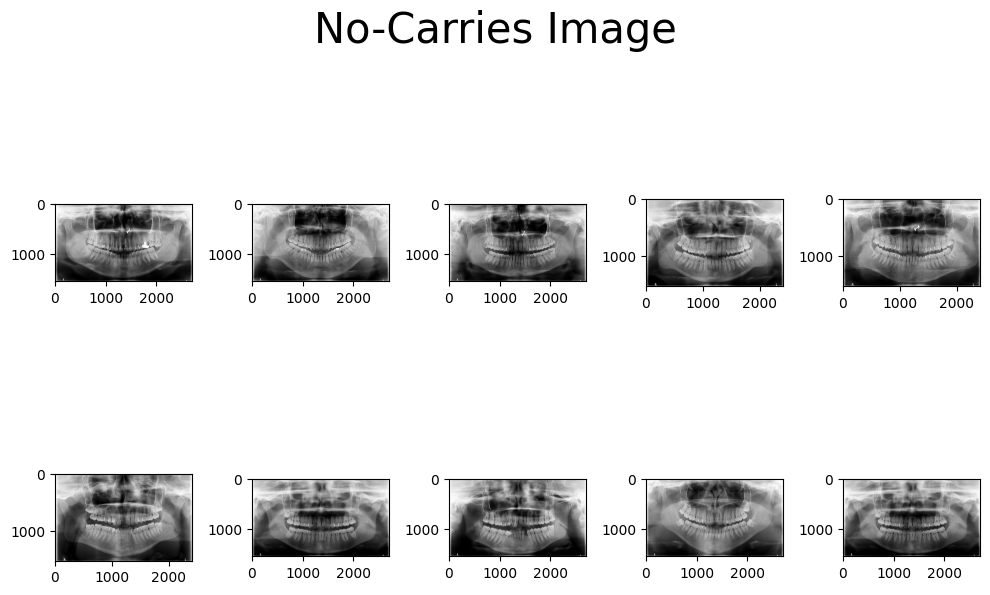

In [15]:
f , ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
f.suptitle('No-Carries Image',x=0.5,y=0.8,fontsize=30,verticalalignment='bottom')
k = 0
for i in range(2):
    for j in range(5):
        img = cv2.imread(os.path.join('C:/Users/User-pc/Downloads/Python/dataset_project','train','no-caries',random.choice(os.listdir(os.path.join('C:/Users/User-pc/Downloads/Python/dataset_project','train','no-caries')))))
        # im_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
        ax[i,j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        k = k + 1
    plt.tight_layout()


In [16]:
train_generator = ImageDataGenerator( 
    rescale = 1.0/255.,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=(0.5, 1.5),
)
val_generator = ImageDataGenerator(rescale=1./255.)


In [17]:
train_datagen = train_generator.flow_from_directory(
    train_folder, 
    batch_size=10,
    target_size=(224, 224)
)
val_datagen = val_generator.flow_from_directory(
    test_folder, 
    batch_size=round(len(df_test)/2), # 14/2 = 7
    target_size=(224, 224)
)


Found 128 images belonging to 2 classes.
Found 55 images belonging to 2 classes.


Found 128 images belonging to 2 classes.


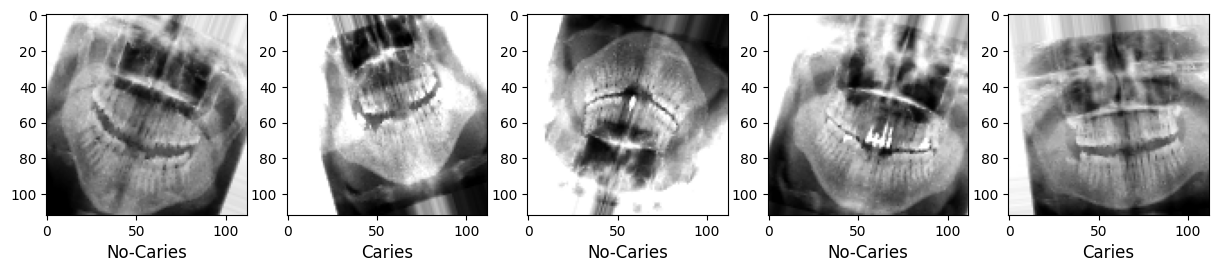

In [18]:
pic = train_generator.flow_from_directory(
    train_folder, 
    batch_size=1,
    target_size=(112, 112))
f,ax = plt.subplots(1,5)
f.set_figheight(15)
f.set_figwidth(15)
for i in range(5):
    img, label = pic.next()
    ax[i].imshow(img[0])
    ax[i].set_xlabel('Caries' if np.argmax(label) == 0 else 'No-Caries',fontsize=12)


In [19]:
base_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3),weights=None,include_top=False,classes=2)

In [20]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.6))
model.add(Dense(2, activation="softmax"))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 5

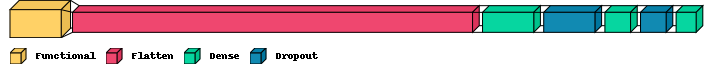

In [21]:
from PIL import ImageFont
font = ImageFont.load_default()
visualkeras.layered_view(model, legend=True, font=font,to_file='output.png')  # font is optional!


In [22]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)


In [23]:
path_checkpoint = 'tmp/efficienetb0_checkpoint'
os.makedirs(path_checkpoint,exist_ok=True)

Checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc',
                                                 verbose=1)
callback = [Checkpoint, 
             tf.keras.callbacks.EarlyStopping(patience = 5, monitor= "val_acc",verbose=1),
             tf.keras.callbacks.TensorBoard(log_dir = "logs/{}".format('Toothdecay'))]


In [24]:
history = model.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=50,
    callbacks=[
        callback
    ]
)


Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.5781 
Epoch 1: saving model to best_model.h5
13/13 [==============================] - 164s 13s/step - loss: 0.6898 - accuracy: 0.5781 - val_loss: 0.6750 - val_accuracy: 0.6182
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 0.6877 - accuracy: 0.6094 
Epoch 2: saving model to best_model.h5
13/13 [==============================] - 172s 13s/step - loss: 0.6877 - accuracy: 0.6094 - val_loss: 0.6687 - val_accuracy: 0.6182
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 0.7712 - accuracy: 0.6172 
Epoch 3: saving model to best_model.h5
13/13 [==============================] - 172s 13s/step - loss: 0.7712 - accuracy: 0.6172 - val_loss: 0.6759 - val_accuracy: 0.6182
Epoch 4/50
13/13 [==============================] - ETA: 0s - loss: 0.6773 - accuracy: 0.6094 
Epoch 4: saving model to best_model.h5
13/13 [==============================] - 171s 13s/step - loss: 0.6773 -